# <h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 25px; color: #2D2926; text-align: center; line-height: 0.75;background-color: #41dcf7"><b>Fraud Detection in Credit Card Dataset: A Classification Problem</b><br></h1>

As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!

### Summary of what was done:

- An exploratory data analysis was conducted to examine the skewness and correlation of the dataset.
- Average precision, recall, precision, and F1-score are all metrics used to evaluate the model's performance. Another metric that could be utilized is the F-beta score, which allows for giving slightly more weight to recall and reducing false negatives.
- To address the issue of imbalanced data, such as in the case of fraud detection, undersampling methods (Random Undersampling, Nearest Neighbors) and oversampling method (SMOTE) were employed to enhance the model's results.
- In relation to the original dataset, the train, validation, and test sets were split based on chronological order, with a gap of 5% of the data (using a prequential approach with a delay). This approach was adopted to ensure that the model always predicts future transactions using past data.
- To improve the hyperparameters of the models, optimization was performed using the Optuna library with the TPE optimizer. The metric used for optimization was the average precision, aiming to maximize it and select the best model configuration.
- After selecting the best model, the optimal threshold was chosen to maximize the F1-score metric, achieving a good and balanced trade-off between recall and precision.
- Shapley values were utilized to determine the importance of each feature in the model. These values allowed us to examine why the model correctly predicted instances (both true positives and true negatives) and which feature contributed to those predictions. Additionally, Shapley values provided insights into the reasons behind incorrect predictions (both false positives and false negatives) and the corresponding features responsible for those errors.
- What else could be done? The features with near-zero Shapley values should be either removed or combined with others.

### Links:

[Link to dataset on kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)


# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Data Preprocessing/Information</div></center>

### Importing Libraries:

In [116]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedShuffleSplit, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, make_scorer, roc_curve, average_precision_score, balanced_accuracy_score, precision_recall_curve, confusion_matrix
import matplotlib.patches as mpatches
import optuna

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler, EditedNearestNeighbours
from imblearn.metrics import classification_report_imbalanced

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

import shap
shap.initjs()

### Data Reading:

In [2]:
df_raw = pd.read_csv('creditcard.csv')
df_raw

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Data info:

In [3]:
df_raw.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df_raw.describe()[['Time', 'Amount', 'Class']]

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [5]:
df_raw.isna().sum().to_frame().T
print(f'How many cols with nulls: {(~df_raw.isna().sum() == 0).sum()}')

How many cols with nulls: 0


In [6]:
print(f'No fraud: {df_raw["Class"].value_counts(normalize=True)[0]*100:.2f}%')
print(f'Fraud: {df_raw["Class"].value_counts(normalize=True)[1]*100:.2f}%')

No fraud: 99.83%
Fraud: 0.17%


# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Exploratory Data Analysis</div></center>

The features are well distributed when .skew() is around 0 (symmetric). 
- When -1 > .skew() > 1, the data is considered highly skewed.
- When .skew() > 0, the data has positive skewness (right-skewed).
- When .skew() < 0, the data has negative skewness (left-skewed).

<Axes: >

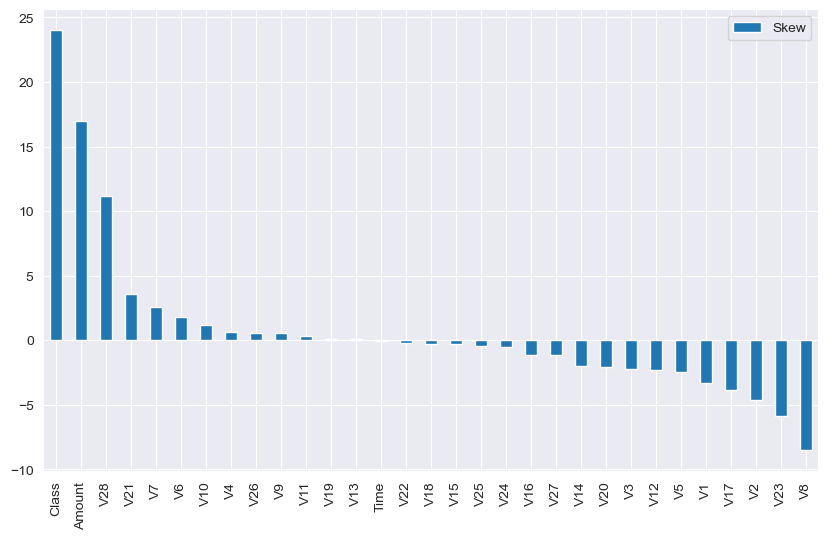

In [7]:
df_raw.skew().sort_values(ascending=False).to_frame(name='Skew').plot.bar(figsize=(10,6))

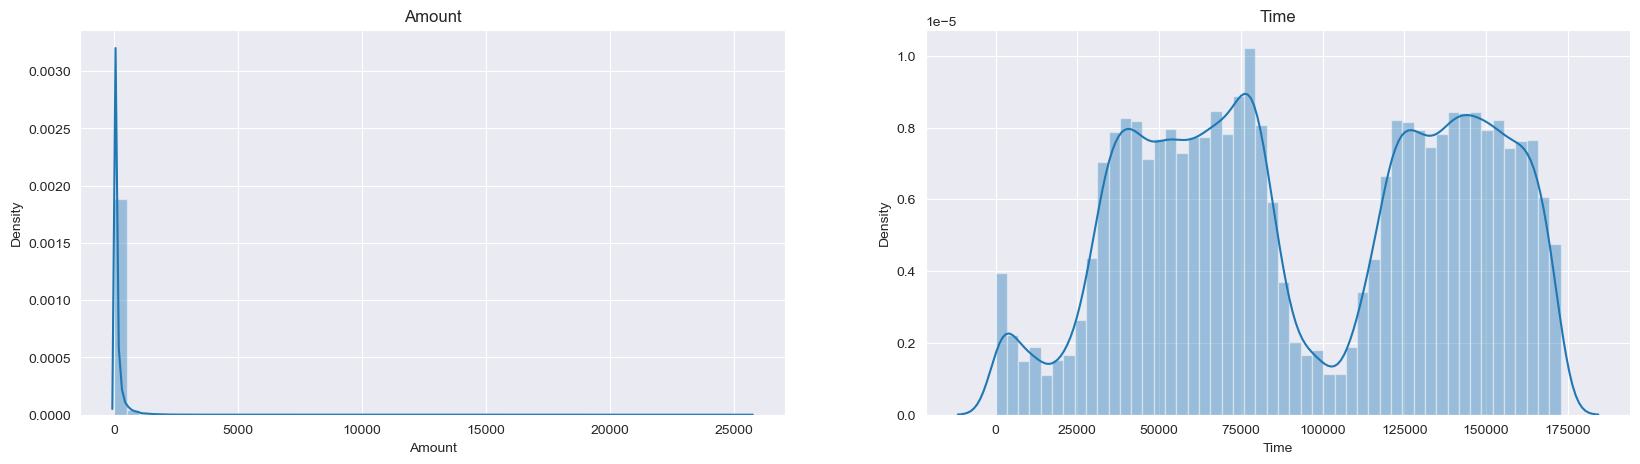

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.distplot(df_raw['Amount'], ax=ax[0])
ax[0].set_title('Amount')

sns.distplot(df_raw['Time'], ax=ax[1])
ax[1].set_title('Time')

plt.show()

### Correlation Matrices:¶

<Axes: >

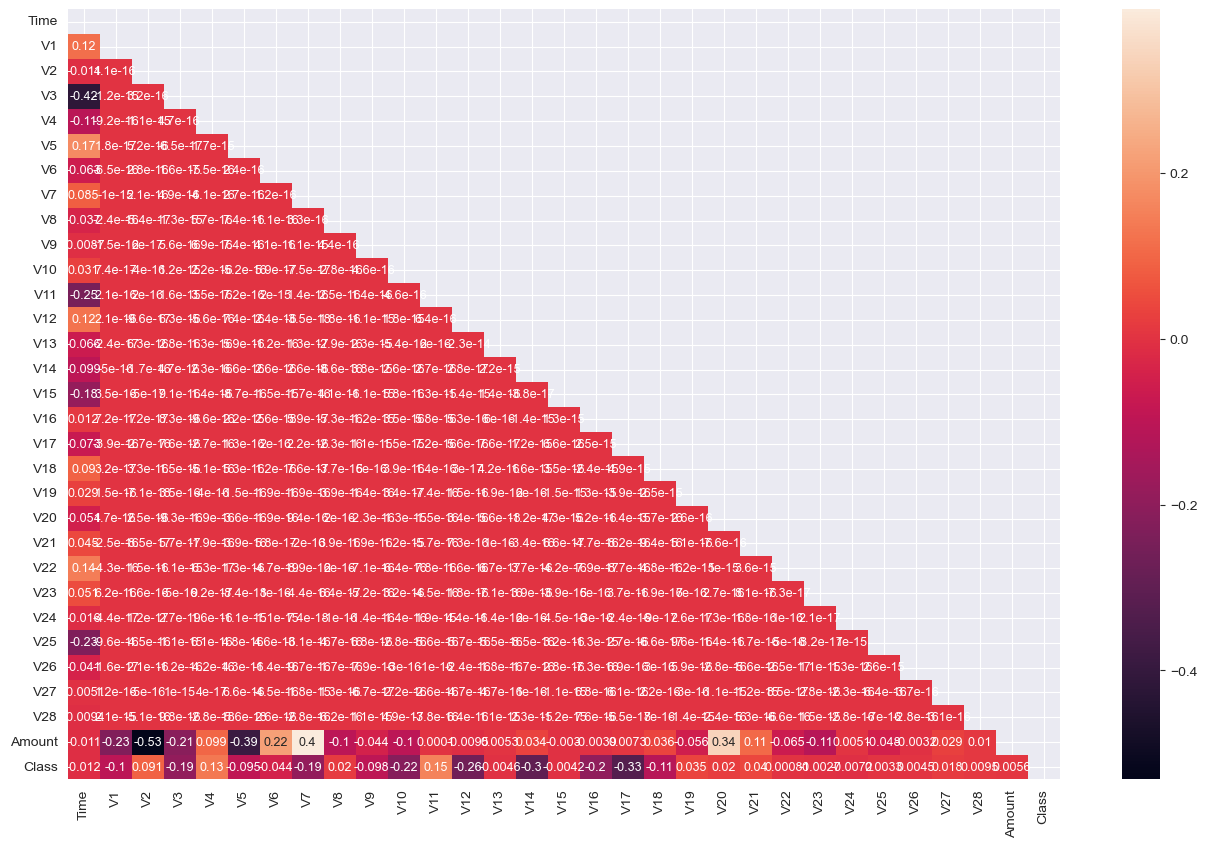

In [9]:
plt.figure(figsize=(16, 10))
annot_font_size = 9
coors = df_raw.corr()#method='spearman'
mask = np.zeros_like(coors, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(coors, mask=mask, annot=True, annot_kws={"size": annot_font_size})

# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Feature Engineering</div></center>

### Feature Scaling:

In [10]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df_raw['scaled_Amount'] = rob_scaler.fit_transform(df_raw['Amount'].to_numpy().reshape(-1, 1))
df_raw['scaled_Time'] = rob_scaler.fit_transform(df_raw['Time'].to_numpy().reshape(-1, 1))
df_raw = df_raw.drop(['Time','Amount'], axis=1)

df_raw.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_Amount,scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [11]:
df_raw_sc = pd.DataFrame(std_scaler.fit_transform(df_raw.iloc[:,:-3].to_numpy()), columns=df_raw.iloc[:,:-3].columns)
df_raw_sc = df_raw_sc.merge(df_raw.iloc[:,-3:], left_index=True, right_index=True)
df_raw_sc.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_Amount,scaled_Time
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0,1.783274,-0.994983
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,0,-0.269825,-0.994983
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,0,4.983721,-0.994972
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0,1.418291,-0.994972
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,0,0.670579,-0.994960


## Train and Test Split

In fraud detection, its crucial to predict future occurrences based on past patterns. Therefore, when constructing the train, validation, and test datasets, its important to maintain a chronological order. Sometimes a delay is implemented between the train and test datasets. An example of one split is: 7 days of training, 7 days of delay and 7 days of test, following a time order.

### Metrics:

- **AUC ROC (Area Under the Curve)** is a good metric to evaluate performance and compare models for balanced datasets. However, when dealing with imbalanced data, the higher number of TNs (True Negatives) leads to a lower FPR (False Positive Rate), which can inflate the AUC score and make it appear higher. Therefore, while AUC can still provide some information about the model's performance, it should be interpreted with caution in the context of imbalanced datasets.
- **Recall** is the proportion of true actual positives correctly identified by a model among all the actual positive instances. It's a metric that focuses on correctly predicting all the fraudulent transactions, so if the goal is to capture as many fraudulent transactions as possible, recall should be high. However, in doing so, there is a possibility of having a higher number of false positives (low precision), similar to the situation: print(y=1) results in false alerts.
- **Precision** is the proportion of true predicted positives correctly identified by a model among all the predicted positive instances. A high precision means that the majority of the instances predicted as positive by the model are indeed true positives. However, when dealing with high presicion it may result in a higher number of missed fraudulent transactions.
- **Average Precision** is area under the curve of Precision-Recall. Its a good metrics when caring more about positive class, since both precision and recall deals with it.
- **F1-score** is the harmonic mean between precision and recall, providing a balanced measure of both metrics. This metric  places more emphasis on lower values, making it sensitive to the performance of the model on minority classes or rare events. 

### Training and Test Datasets:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_raw_sc.drop('Class', axis=1), df_raw_sc['Class'], test_size=0.2,
                                                    random_state=0, shuffle=False) #, stratify=df_raw['Class']
print(f'N° rows training data set: {X_train.shape[0]}\nN° rows testing data set: {X_test.shape[0]}')

N° rows training data set: 227845
N° rows testing data set: 56962


### Useful Functions:

In [13]:
def cross_val_scores(estimator, X_train, y_train, n_splits = 5):
    
    #Time order CV with 5% data delay
    prequential_cv = TimeSeriesSplit(n_splits=n_splits, gap=int(0.05*X_train.shape[0])) #max_train_size=int(X_train.shape[0]/(nsplits+1))),
    scorer = {'roc_auc': 'roc_auc',
              'average_precision': 'average_precision',
              'balanced_accuracy': 'balanced_accuracy',
              'precision': 'precision',
              'recall': 'recall',
              'f1_score': make_scorer(f1_score)}
    cv_score = cross_validate(estimator=estimator, X=X_train, y=y_train, cv=prequential_cv, 
                              scoring=scorer,
                              return_estimator=True)#['roc_auc','average_precision','balanced_accuracy','precision', 'recall']
    
    df_cv_score=round(pd.DataFrame(cv_score).iloc[:, 3:], 3)
    df_cv_score = df_cv_score.mean().to_frame().T
    df_cv_score.columns = ['roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score']
    
    return df_cv_score

def kfold_cv_with_classifier(classifier, X_train, y_train, n_splits=5):
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    scorer = {'roc_auc': 'roc_auc',
              'average_precision': 'average_precision',
              'balanced_accuracy': 'balanced_accuracy',
              'precision': 'precision',
              'recall': 'recall',
              'f1_score': make_scorer(f1_score)}
    
    cv_score = cross_validate(classifier, X=X_train, y=y_train, cv=cv, 
                                scoring=scorer,
                                return_estimator=True)
    
    df_cv_score=round(pd.DataFrame(cv_score).iloc[:, 3:], 3)
    df_cv_score = df_cv_score.mean().to_frame().T
    df_cv_score.columns = ['roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score']
    
    return df_cv_score

def test_scores(best_estimator, X_test, y_test):
    
    y_proba_scores = best_estimator.predict_proba(X_test)[:, 1]
    y_score = best_estimator.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_proba_scores)
    average_precision = average_precision_score(y_test, y_proba_scores)
    balanced_accuracy = balanced_accuracy_score(y_test, y_score)
    precision =  precision_score(y_test, y_score) 
    recall = recall_score(y_test, y_score) 
    f1score = f1_score(y_test, y_score)
    
    scores = pd.DataFrame({'roc_auc': [roc_auc], 'average_precision': [average_precision], 'balanced_accuracy': [balanced_accuracy],
                          'precision': [precision], 'recall': [recall], 'f1_score': [f1score]})
    scores = np.round(scores, 3)
    return scores

def optuna_log(trial): ## 1 = Average precision

    params_log = {"C" : trial.suggest_loguniform('C', 0.1, 10.0),
                    "max_iter" : trial.suggest_int('max_iter', 100, 5000),
                    "solver": trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs']),
                    "penalty": trial.suggest_categorical('penalty', ['l2'])
                     }
    estimator_optuna = LogisticRegression(**params_log)
    
    scores = cross_val_scores(estimator_optuna, X_train, y_train)
    
    return scores['average_precision'] ## Average precision

def fig_tnse_PCA(X_fig, y_fig):
    model_tnse = TSNE(n_components=2, random_state=30).fit_transform(X_fig)
    model_PCA = PCA(n_components=2, random_state=30).fit_transform(X_fig)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
    red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

    plt.subplot(1,2,1)
    plt.title('TNSE model')
    plt.scatter(model_tnse[:,0], model_tnse[:,1], c=(y_fig == 0), cmap='coolwarm', label='No Fraud')
    plt.scatter(model_tnse[:,0], model_tnse[:,1], c=(y_fig == 1), cmap='coolwarm', label='Fraud')
    plt.legend(handles=[blue_patch, red_patch])

    plt.subplot(1,2,2)
    plt.title('PCA model')
    plt.scatter(model_PCA[:,0], model_PCA[:,1], c=(y_fig == 0), cmap='coolwarm', label='No Fraud')
    plt.scatter(model_PCA[:,0], model_PCA[:,1], c=(y_fig == 1), cmap='coolwarm', label='Fraud')
    plt.legend(handles=[blue_patch, red_patch])

# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Machine Learning Models</div></center>

## Logistic Regression:

#### Cross Validation (Raw Train Data):

In [14]:
cross_val_scores(LogisticRegression(), X_train, y_train)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.942,0.6076,0.7252,0.7744,0.4504,0.5506


#### Model Tuning:

In [15]:
study_log = optuna.create_study(direction = "maximize")
study_log.optimize(optuna_log, n_trials = 10)

[I 2023-07-14 09:56:01,274] A new study created in memory with name: no-name-58ce96d5-fa2b-4915-825c-001f5fd98355
[I 2023-07-14 09:56:22,776] Trial 0 finished with value: 0.6024 and parameters: {'C': 3.4638408556957363, 'max_iter': 3809, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 0 with value: 0.6024.
[I 2023-07-14 09:56:46,864] Trial 1 finished with value: 0.6046 and parameters: {'C': 1.685558079534258, 'max_iter': 2000, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 1 with value: 0.6046.
[I 2023-07-14 09:57:03,774] Trial 2 finished with value: 0.603 and parameters: {'C': 2.811254297168472, 'max_iter': 2258, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 1 with value: 0.6046.
[I 2023-07-14 09:57:21,344] Trial 3 finished with value: 0.6026 and parameters: {'C': 3.3639244453558113, 'max_iter': 3573, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 1 with value: 0.6046.
[I 2023-07-14 09:57:43,085] Trial 4 finished with value: 0.6064 and parameters: {'C': 1.32883

In [16]:
best_params = study_log.best_params
best_model =  LogisticRegression(**best_params).fit(X_train, y_train)
test_scores(best_model, X_test, y_test)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.975,0.739,0.78,0.913,0.56,0.694


## Random Undersampling Technique:

In RUS we take only a few random samples of the majority class. Case sampling_strategy=1, both classes going to have same size.  It is important to note that chronological order is not maintained.

In [17]:
RUS = RandomUnderSampler(sampling_strategy=1, random_state=12)
X_train_RUS, y_train_RUS = RUS.fit_resample(X_train, y_train)
scores = kfold_cv_with_classifier(LogisticRegression(), X_train_RUS, y_train_RUS)
scores

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.976,0.9824,0.9424,0.9676,0.9162,0.941


#### Visualizing the Dataset (PCA and t-SNE):

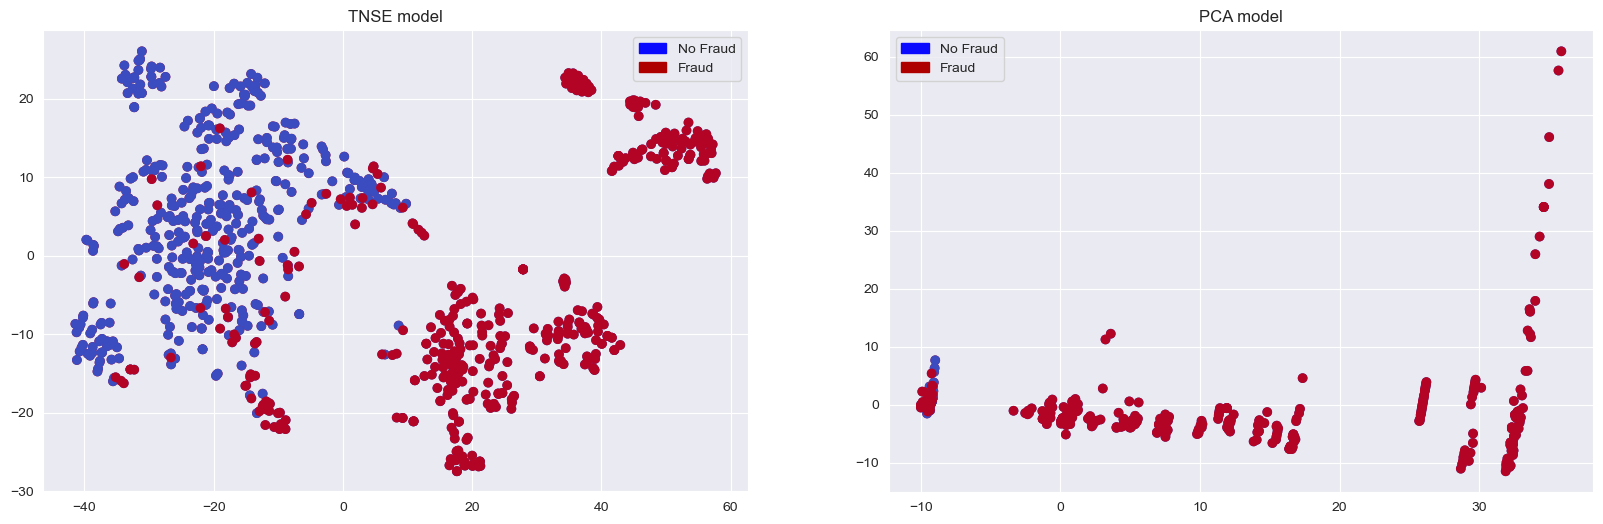

In [18]:
fig_tnse_PCA(X_train_RUS, y_train_RUS)

#### Model Tuning:

In [19]:
#Tunnig Logistic Regression with RUS technique
def optuna_log_RUS(trial): ## 1 = Average precision

    params_log = {"C" : trial.suggest_loguniform('C', 0.1, 10.0),
                    "max_iter" : trial.suggest_int('max_iter', 100, 5000),
                    "solver": trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs']),
                    "penalty": trial.suggest_categorical('penalty', ['l2'])
                     }
    estimator_optuna = LogisticRegression(**params_log)
    
    scores = kfold_cv_with_classifier(estimator_optuna, X_train_RUS, y_train_RUS)
    
    return scores['average_precision'] ## Average precision
study_log_RUS = optuna.create_study(direction = "maximize")
study_log_RUS.optimize(optuna_log_RUS, n_trials = 200)

[I 2023-07-14 09:59:32,989] A new study created in memory with name: no-name-128d4e39-c7b1-4b12-a8c9-a8f2729e24ac
[I 2023-07-14 09:59:33,256] Trial 0 finished with value: 0.9833999999999999 and parameters: {'C': 0.1448384577559767, 'max_iter': 684, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 0 with value: 0.9833999999999999.
[I 2023-07-14 09:59:33,448] Trial 1 finished with value: 0.9822 and parameters: {'C': 6.014340058172608, 'max_iter': 4153, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 0 with value: 0.9833999999999999.
[I 2023-07-14 09:59:33,753] Trial 2 finished with value: 0.983 and parameters: {'C': 0.3610042733952457, 'max_iter': 4828, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 0 with value: 0.9833999999999999.
[I 2023-07-14 09:59:33,971] Trial 3 finished with value: 0.9836 and parameters: {'C': 0.12722106017948587, 'max_iter': 943, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9836.
[I 2023-07-14 09:59:34,284] Trial 4 finished 

[I 2023-07-14 09:59:44,277] Trial 40 finished with value: 0.9833999999999999 and parameters: {'C': 0.16057323959673814, 'max_iter': 3794, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:44,523] Trial 41 finished with value: 0.984 and parameters: {'C': 0.10068654805299035, 'max_iter': 3554, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:44,776] Trial 42 finished with value: 0.984 and parameters: {'C': 0.1216501745799229, 'max_iter': 2969, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:45,012] Trial 43 finished with value: 0.984 and parameters: {'C': 0.10224505158151373, 'max_iter': 2462, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:45,219] Trial 44 finished with value: 0.983 and parameters: {'C': 0.14996078581071573, 'max_iter': 3347, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 11 with value: 0

[I 2023-07-14 09:59:56,928] Trial 81 finished with value: 0.984 and parameters: {'C': 0.1006155464372327, 'max_iter': 1580, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:57,181] Trial 82 finished with value: 0.984 and parameters: {'C': 0.1095796016875337, 'max_iter': 2205, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:57,450] Trial 83 finished with value: 0.9833999999999999 and parameters: {'C': 0.14999841111107573, 'max_iter': 3506, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:57,711] Trial 84 finished with value: 0.9837999999999999 and parameters: {'C': 0.12632504233185057, 'max_iter': 3677, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 09:59:57,956] Trial 85 finished with value: 0.984 and parameters: {'C': 0.10025213307768494, 'max_iter': 2025, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with 

[I 2023-07-14 10:00:11,394] Trial 121 finished with value: 0.984 and parameters: {'C': 0.1156528646821809, 'max_iter': 2414, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 10:00:11,798] Trial 122 finished with value: 0.984 and parameters: {'C': 0.12145493316755393, 'max_iter': 2150, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 10:00:12,161] Trial 123 finished with value: 0.9836 and parameters: {'C': 0.1357632490799136, 'max_iter': 3787, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 10:00:12,449] Trial 124 finished with value: 0.984 and parameters: {'C': 0.11131033127316083, 'max_iter': 3648, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 0.984.
[I 2023-07-14 10:00:12,725] Trial 125 finished with value: 0.9837999999999999 and parameters: {'C': 0.12561091199752442, 'max_iter': 2489, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 11 with value: 

[I 2023-07-14 10:00:30,744] Trial 161 finished with value: 0.984 and parameters: {'C': 0.12190301079632733, 'max_iter': 3211, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 151 with value: 0.9842000000000001.
[I 2023-07-14 10:00:31,163] Trial 162 finished with value: 0.984 and parameters: {'C': 0.11130426943663323, 'max_iter': 3080, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 151 with value: 0.9842000000000001.
[I 2023-07-14 10:00:31,564] Trial 163 finished with value: 0.983 and parameters: {'C': 0.35279296263495646, 'max_iter': 3500, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 151 with value: 0.9842000000000001.
[I 2023-07-14 10:00:31,903] Trial 164 finished with value: 0.9833999999999999 and parameters: {'C': 0.15245053587176588, 'max_iter': 3364, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 151 with value: 0.9842000000000001.
[I 2023-07-14 10:00:32,372] Trial 165 finished with value: 0.984 and parameters: {'C': 0.1195107037788831, 'max_iter': 2969, 'solver': 

[I 2023-07-14 10:00:45,073] Trial 199 finished with value: 0.9833999999999999 and parameters: {'C': 0.15752874671958944, 'max_iter': 3743, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 151 with value: 0.9842000000000001.


In [20]:
best_params_RUS = study_log_RUS.best_params
best_model_RUS =  LogisticRegression(**best_params_RUS).fit(X_train_RUS, y_train_RUS)
test_scores(best_model_RUS, X_test, y_test)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.987,0.632,0.931,0.059,0.88,0.11


## Edited Nearest Neighbours:
ENN is undersampling techniques that removes samples from majority class in overlapping regions.
- For each majority class sample, the k-nearest neighbors are found. If the majority are from minority, the majority is removed.
- For each minority class sample, the k-nearest neighbors are found. If the majority are from majority, the majority is removed.

In [21]:
#ENN = EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=3, n_jobs=-1)
#X_train_ENN, y_train_ENN = ENN.fit_resample(X_train, y_train)

## Near Miss Undersampling Technique:
NearMiss is an undersampling technique that aims to reduce samples from the majority class based on their proximity to the minority class. It focuses on removing majority samples that are close to the minority class in order to improve the classification performance of the minority class. The goal is to refine the boundary region between the classes. (k-nearest neighbors the method is used)

In [22]:
NM = NearMiss(sampling_strategy='majority', n_neighbors=3, n_jobs=-1)
X_train_NM, y_train_NM = NM.fit_resample(X_train, y_train)
scores_MN = kfold_cv_with_classifier(LogisticRegression(), X_train_NM, y_train_NM)
scores_MN

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.9912,0.994,0.9736,0.99,0.9568,0.973


#### Visualizing the Dataset (PCA and t-SNE):

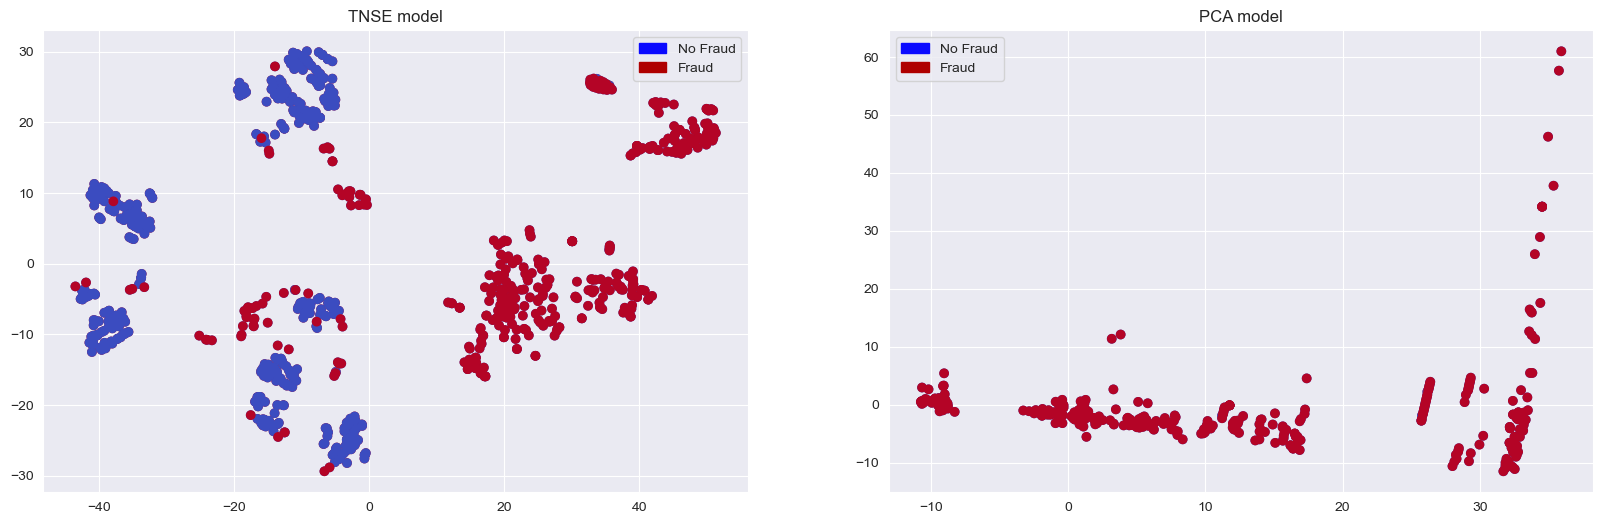

In [23]:
fig_tnse_PCA(X_train_NM, y_train_NM)

#### Model Tuning:

In [24]:
#Tunnig Logistic Regression with NearMiss technique
def optuna_log_NM(trial): ## 1 = Average precision

    params_log = {"C" : trial.suggest_loguniform('C', 0.1, 10.0),
                    "max_iter" : trial.suggest_int('max_iter', 100, 5000),
                    "solver": trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs']),
                    "penalty": trial.suggest_categorical('penalty', ['l2'])
                     }
    estimator_optuna = LogisticRegression(**params_log)
    
    scores = kfold_cv_with_classifier(estimator_optuna, X_train_NM, y_train_NM)
    
    return scores['average_precision'] ## Average precision
study_log_NM = optuna.create_study(direction = "maximize")
study_log_NM.optimize(optuna_log_NM, n_trials = 200)

[I 2023-07-14 10:00:58,823] A new study created in memory with name: no-name-8d43f2e9-50f6-48d5-ae16-dd8d35dd705e
[I 2023-07-14 10:00:59,583] Trial 0 finished with value: 0.9934 and parameters: {'C': 0.25234928833773196, 'max_iter': 929, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 0 with value: 0.9934.
[I 2023-07-14 10:01:00,018] Trial 1 finished with value: 0.994 and parameters: {'C': 1.054860938871105, 'max_iter': 1852, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 1 with value: 0.994.
[I 2023-07-14 10:01:00,404] Trial 2 finished with value: 0.9934 and parameters: {'C': 0.37669960013127346, 'max_iter': 1407, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 1 with value: 0.994.
[I 2023-07-14 10:01:00,812] Trial 3 finished with value: 0.9942 and parameters: {'C': 1.8973137863802707, 'max_iter': 1030, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:01,117] Trial 4 finished with value: 0.9934 and parameters: {'C': 0.27664

[I 2023-07-14 10:01:17,464] Trial 41 finished with value: 0.994 and parameters: {'C': 2.3393670340221226, 'max_iter': 4747, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:17,870] Trial 42 finished with value: 0.9942 and parameters: {'C': 1.9728603750666278, 'max_iter': 4446, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:18,269] Trial 43 finished with value: 0.9937999999999999 and parameters: {'C': 2.5937816927685646, 'max_iter': 5000, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:18,624] Trial 44 finished with value: 0.994 and parameters: {'C': 1.4358749944290772, 'max_iter': 1281, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:19,119] Trial 45 finished with value: 0.9936 and parameters: {'C': 3.542928727074356, 'max_iter': 4372, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[

[I 2023-07-14 10:01:34,001] Trial 82 finished with value: 0.9942 and parameters: {'C': 1.820034160943362, 'max_iter': 1067, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:34,476] Trial 83 finished with value: 0.9937999999999999 and parameters: {'C': 2.6007035297112955, 'max_iter': 4608, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:34,716] Trial 84 finished with value: 0.994 and parameters: {'C': 2.2434553219410107, 'max_iter': 4728, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:35,158] Trial 85 finished with value: 0.9936 and parameters: {'C': 3.1931630619534914, 'max_iter': 2711, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:35,524] Trial 86 finished with value: 0.994 and parameters: {'C': 1.295903256891646, 'max_iter': 4498, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942

[I 2023-07-14 10:01:51,903] Trial 123 finished with value: 0.9942 and parameters: {'C': 2.1285460209647886, 'max_iter': 4754, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:52,344] Trial 124 finished with value: 0.9942 and parameters: {'C': 1.7124912239840295, 'max_iter': 4996, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:52,756] Trial 125 finished with value: 0.994 and parameters: {'C': 1.3318518434741016, 'max_iter': 4885, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:53,207] Trial 126 finished with value: 0.9942 and parameters: {'C': 1.9586790682108963, 'max_iter': 2778, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:01:53,675] Trial 127 finished with value: 0.9937999999999999 and parameters: {'C': 2.707408608725, 'max_iter': 4510, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942

[I 2023-07-14 10:02:11,154] Trial 164 finished with value: 0.9942 and parameters: {'C': 1.8089935630850111, 'max_iter': 4042, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:02:11,596] Trial 165 finished with value: 0.9942 and parameters: {'C': 2.17545157419983, 'max_iter': 4679, 'solver': 'newton-cg', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:02:12,055] Trial 166 finished with value: 0.994 and parameters: {'C': 1.558114974434171, 'max_iter': 252, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:02:12,625] Trial 167 finished with value: 0.994 and parameters: {'C': 2.310571445202899, 'max_iter': 3910, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2023-07-14 10:02:13,294] Trial 168 finished with value: 0.9942 and parameters: {'C': 1.9317450640127776, 'max_iter': 4752, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 3 with value: 0.9942.
[I 2

In [25]:
best_params_NM = study_log_NM.best_params
best_model_NM =  LogisticRegression(**best_params_NM).fit(X_train_NM, y_train_NM)
test_scores(best_model_NM, X_test, y_test)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.847,0.005,0.653,0.002,0.987,0.004


### SMOTE Oversampling Technique:
SMOTE is an oversampling technique that creates synthetic examples by generating new instances near the existing minority class samples. To avoid data leakage, the SMOTE algorithm should be applied only to the training data, while keeping the validation data untouched. This ensures that the synthetic samples generated by SMOTE do not influence the evaluation of the model on unseen data.

In [26]:
smote = SMOTE(sampling_strategy=1, n_jobs=-1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
def smote_technique(estimator, X, y, n_splits=5):

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    results = []
    for train_index, test_index in cv.split(X, y):
        pipeline_im = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), estimator)
        model_smote = pipeline_im.fit(X.iloc[train_index], y.iloc[train_index])
        results.append(test_scores(model_smote, X.iloc[test_index], y.iloc[test_index]))
    results_mean = pd.DataFrame(np.mean(results, axis=0),
                                columns=['roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score'])
    return results_mean

a = smote_technique(LogisticRegression(), X_train, y_train)
a

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.9744,0.7318,0.9468,0.07,0.9164,0.1298


In [27]:
#fig_tnse_PCA(X_train_smote, y_train_smote)

#### Model Tuning:

In [28]:
#Tunnig Logistic Regression with SMOTE technique
def optuna_log_SMOTE(trial): ## 1 = Average precision

    params_log = {"C" : trial.suggest_loguniform('C', 0.1, 10.0),
                    "max_iter" : trial.suggest_int('max_iter', 100, 5000),
                    "solver": trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs']),
                    "penalty": trial.suggest_categorical('penalty', ['l2'])
                     }
    estimator_optuna = LogisticRegression(**params_log)
    
    scores = smote_technique(estimator_optuna, X_train, y_train)
    
    return scores['average_precision']
study_log_smote = optuna.create_study(direction = "maximize")
study_log_smote.optimize(optuna_log_SMOTE, n_trials = 10)

[I 2023-07-14 10:02:51,136] A new study created in memory with name: no-name-aa235a5d-59e7-4456-947e-aa118950da45
[I 2023-07-14 10:03:16,927] Trial 0 finished with value: 0.7333999999999999 and parameters: {'C': 5.664551536946325, 'max_iter': 1777, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 0 with value: 0.7333999999999999.
[I 2023-07-14 10:04:00,226] Trial 1 finished with value: 0.7342000000000001 and parameters: {'C': 1.045741488323514, 'max_iter': 3151, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.7342000000000001.
[I 2023-07-14 10:04:25,996] Trial 2 finished with value: 0.7324 and parameters: {'C': 1.9584939675667727, 'max_iter': 1471, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 1 with value: 0.7342000000000001.
[I 2023-07-14 10:05:10,988] Trial 3 finished with value: 0.732 and parameters: {'C': 3.4608874416751814, 'max_iter': 1850, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.7342000000000001.
[I 2023-07-14 10:05:5

In [29]:
best_params_smote = study_log_smote.best_params
best_model_smote =  LogisticRegression(**best_params_smote).fit(X_train_smote, y_train_smote)
test_scores(best_model_smote, X_test, y_test)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.986,0.773,0.931,0.063,0.88,0.118


## Summarized Evaluation of Test Data:

In [30]:
data_models = {'Basic_model': [X_train, y_train], 'RUS_model': [X_train_RUS, y_train_RUS], 'NearMiss_model': [X_train_NM, y_train_NM],
        'SMOTE_model': [X_train_smote, y_train_smote]}
df_result = pd.DataFrame(columns=['roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score']) 
for key, data in data_models.items():
    model = LogisticRegression().fit(data[0], data[1])
    scores = test_scores(model, X_test, y_test)
    df_result.loc[key] = scores.iloc[0]
df_result

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
Basic_model,0.975,0.737,0.780,0.913,0.560,0.694
RUS_model,0.987,0.724,0.932,0.065,0.880,0.120
NearMiss_model,0.873,0.006,0.672,0.002,0.987,0.004
SMOTE_model,0.986,0.773,0.931,0.063,0.880,0.118


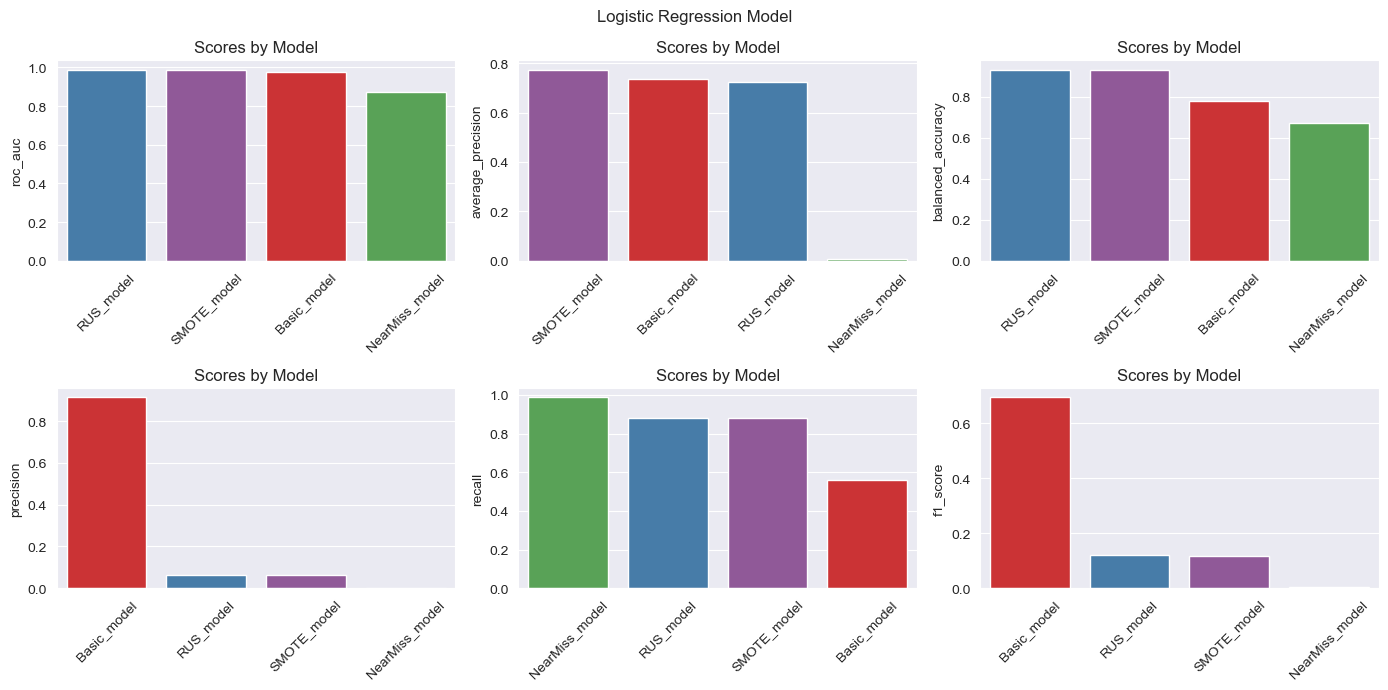

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(14, 7))
fig.suptitle('Logistic Regression Model')
color_palette = sns.color_palette('Set1', n_colors=len(data_models))
model_colors = dict(zip(df_result.index, color_palette))
for i, metric in enumerate(df_result.columns):
    plt.title('Scores by Model')
    plt.subplot(2,3,i+1)
    sorted_df = df_result.sort_values(metric, ascending=False)
    sns.barplot(x=sorted_df.index, y=sorted_df[metric], palette=model_colors)
    plt.xticks(rotation=45)
    
fig.tight_layout()

## Random Forest Model:

#### Cross Validation (Raw Train Data):

In [32]:
cross_val_scores(RandomForestClassifier(n_estimators=10), X_train, y_train)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.9244,0.7536,0.8462,0.8698,0.6928,0.7618


#### Model Tuning:

In [33]:
def optuna_rf(trial): ## 1 = Average precision

    params_rf = {'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}
    
                #'n_estimators': trial.suggest_int('n_estimators', 100, 200, step=10),
    estimator_optuna = RandomForestClassifier(n_estimators=10, **params_rf, n_jobs=-1)
    
    scores = cross_val_scores(estimator_optuna, X_train, y_train)
    
    return scores['average_precision'] ## Average precision
study_rf = optuna.create_study(direction = "maximize")
study_rf.optimize(optuna_rf, n_trials = 10)

[I 2023-07-14 10:11:25,056] A new study created in memory with name: no-name-a531686e-bae0-4861-8263-41a2665a188b
[I 2023-07-14 10:12:07,534] Trial 0 finished with value: 0.7564 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.7564.
[I 2023-07-14 10:12:41,377] Trial 1 finished with value: 0.7718 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.7718.
[I 2023-07-14 10:13:20,001] Trial 2 finished with value: 0.7358 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7718.
[I 2023-07-14 10:13:43,514] Trial 3 finished with value: 0.7816000000000001 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7816000000000001.
[I 2023-07-14 10:14:22,442] Trial 4 fin

In [34]:
best_params_rf = study_rf.best_params
best_model_rf =  RandomForestClassifier(n_estimators=10, **best_params_rf).fit(X_train, y_train)
scores_rf_basic = test_scores(best_model_rf, X_test, y_test)
scores_rf_basic

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.967,0.765,0.813,0.94,0.627,0.752


## Random Undersampling Technique:

In [35]:
scores = kfold_cv_with_classifier(RandomForestClassifier(n_estimators=100), X_train_RUS, y_train_RUS)
scores

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.9766,0.9822,0.9364,0.9742,0.8972,0.9338


#### Model Tuning:

In [36]:
def optuna_rf_RUS(trial): ## 1 = Average precision

    params_rf = {'n_estimators': trial.suggest_categorical('n_estimators', [100, 150, 200]),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}
    
                #'n_estimators': trial.suggest_int('n_estimators', 100, 200, step=10),
    estimator_optuna = RandomForestClassifier(**params_rf, n_jobs=-1)
    
    scores = kfold_cv_with_classifier(estimator_optuna, X_train_RUS, y_train_RUS)
    
    return scores['average_precision'] ## Average precision
study_rf_rus = optuna.create_study(direction = "maximize")
study_rf_rus.optimize(optuna_rf_RUS, n_trials = 10)

[I 2023-07-14 10:17:16,815] A new study created in memory with name: no-name-2a46a439-b5d9-411b-8678-909efe052366
[I 2023-07-14 10:17:18,708] Trial 0 finished with value: 0.982 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.982.
[I 2023-07-14 10:17:22,159] Trial 1 finished with value: 0.9818000000000001 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.982.
[I 2023-07-14 10:17:24,796] Trial 2 finished with value: 0.9812 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.982.
[I 2023-07-14 10:17:26,580] Trial 3 finished with value: 0.9808 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is 

In [37]:
best_params_rf_rus = study_rf_rus.best_params
best_model_rf_rus =  RandomForestClassifier(**best_params_rf_rus).fit(X_train_RUS, y_train_RUS)
score_rf_rus = test_scores(best_model_rf_rus, X_test, y_test)
score_rf_rus

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.99,0.765,0.933,0.074,0.88,0.136


## Near Miss Undersampling Technique:

In [38]:
scores_MN_rf = kfold_cv_with_classifier(RandomForestClassifier(), X_train_NM, y_train_NM)
scores_MN_rf

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.994,0.9922,0.9856,0.9858,0.9856,0.9854


#### Model Tuning:

In [39]:
def optuna_rf_NM(trial): ## 1 = Average precision

    params_rf = {'n_estimators': trial.suggest_categorical('n_estimators', [100, 150, 200]),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}
    
                #'n_estimators': trial.suggest_int('n_estimators', 100, 200, step=10),
    estimator_optuna = RandomForestClassifier(**params_rf, n_jobs=-1)
    
    scores = kfold_cv_with_classifier(estimator_optuna, X_train_NM, y_train_NM)
    
    return scores['average_precision'] ## Average precision
study_rf_NM = optuna.create_study(direction = "maximize")
study_rf_NM.optimize(optuna_rf_NM, n_trials = 30)

[I 2023-07-14 10:17:47,007] A new study created in memory with name: no-name-281e9519-1653-4b35-9258-53155515f2f0
[I 2023-07-14 10:17:48,866] Trial 0 finished with value: 0.9911999999999999 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9911999999999999.
[I 2023-07-14 10:17:51,613] Trial 1 finished with value: 0.9911999999999999 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9911999999999999.
[I 2023-07-14 10:17:54,147] Trial 2 finished with value: 0.9914 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9914.
[I 2023-07-14 10:17:56,682] Trial 3 finished with value: 0.9904 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_lea

In [40]:
best_params_rf_NM = study_rf_NM.best_params
best_model_rf_NM =  RandomForestClassifier(**best_params_rf_NM).fit(X_train_NM, y_train_NM)
score_rf_NM = test_scores(best_model_rf_NM, X_test, y_test)
score_rf_NM

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.919,0.748,0.503,0.001,1.0,0.003


#### SMOTE Oversampling Technique:

In [41]:
smote_technique(RandomForestClassifier(n_estimators=5), X_train, y_train)

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.9368,0.7932,0.9172,0.8354,0.8344,0.8344


#### Model Tuning:

In [42]:
def optuna_rf_smote(trial): ## 1 = Average precision

    params_rf = {'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}
    
                #'n_estimators': trial.suggest_int('n_estimators', 100, 200, step=10),
    estimator_optuna = RandomForestClassifier(n_estimators=5, **params_rf, n_jobs=-1)
    
    scores = kfold_cv_with_classifier(estimator_optuna, X_train_smote, y_train_smote)
    
    return scores['average_precision'] ## Average precision
study_rf_smote = optuna.create_study(direction = "maximize")
study_rf_smote.optimize(optuna_rf_smote, n_trials = 5)

[I 2023-07-14 10:21:47,293] A new study created in memory with name: no-name-1f11f098-aee6-4cb6-b272-15b399c39749
[I 2023-07-14 10:23:11,973] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.0.
[I 2023-07-14 10:24:15,222] Trial 1 finished with value: 0.999 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.0.
[I 2023-07-14 10:25:02,898] Trial 2 finished with value: 0.9982 and parameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 1.0.
[I 2023-07-14 10:26:14,179] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 1.0.
[I 2023-07-14 10:27:41,877] Trial 4 finished with value: 1.0 and parameters: {'ma

In [43]:
#{'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4,'max_features': 'sqrt'}
best_params_rf_smote = study_rf_smote.best_params
best_model_rf_smote =  RandomForestClassifier(**best_params_rf_smote).fit(X_train_smote, y_train_smote)
score_rf_smote = test_scores(best_model_rf_smote, X_test, y_test)
score_rf_smote

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
0,0.968,0.828,0.88,0.919,0.76,0.832


## Summarized Evaluation of Test Data:

In [44]:
models_rf = {'Basic_model':scores_rf_basic , 'RUS_model':score_rf_rus, 'NearMiss_model':score_rf_NM, 'SMOTE_model':score_rf_smote}
df_result_rf = pd.DataFrame(columns=['roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score']) 
for key, data in models_rf.items():
    df_result_rf.loc[key] = data.values[0]
df_result_rf

,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score
Basic_model,0.967,0.765,0.813,0.940,0.627,0.752
RUS_model,0.990,0.765,0.933,0.074,0.880,0.136
NearMiss_model,0.919,0.748,0.503,0.001,1.000,0.003
SMOTE_model,0.968,0.828,0.880,0.919,0.760,0.832


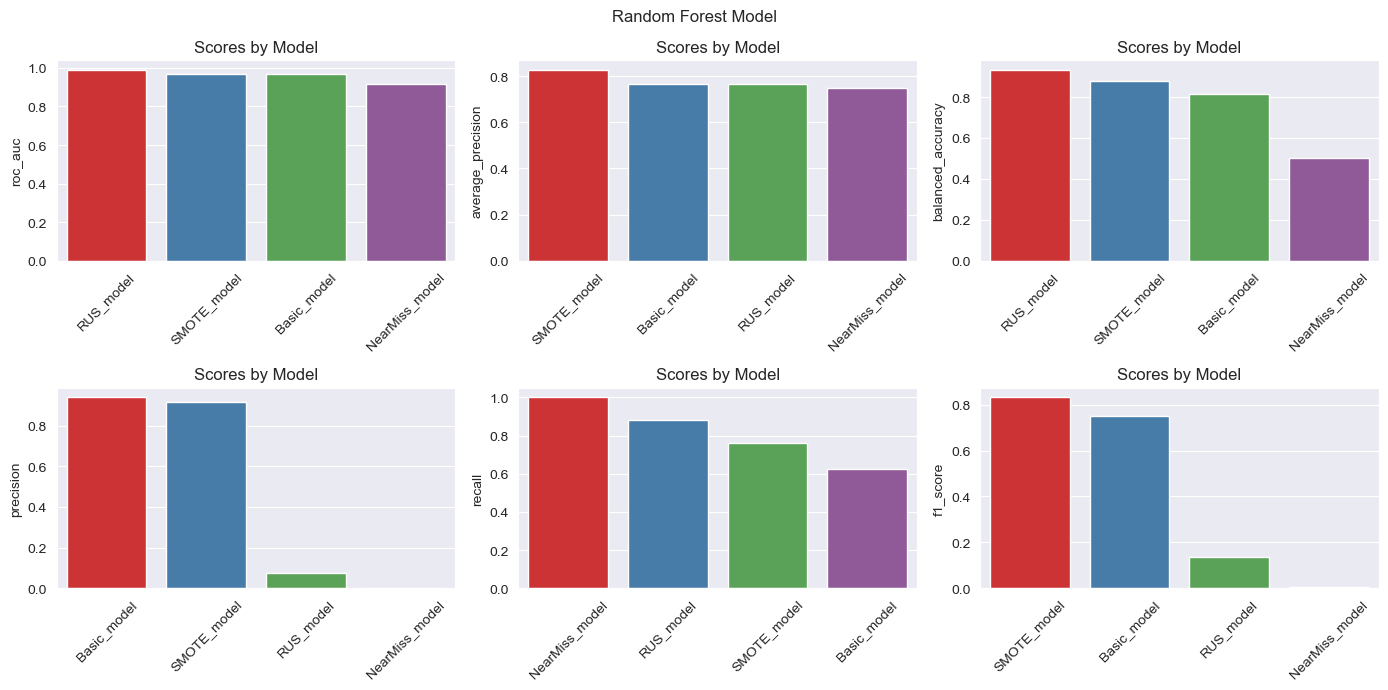

In [45]:
fig1, ax1 = plt.subplots(2, 3, figsize=(14, 7))
fig1.suptitle('Random Forest Model')
color_palette_rf = sns.color_palette('Set1', n_colors=len(models_rf))
model_colors = dict(zip(df_result_rf.index, color_palette))
for i, metric in enumerate(df_result_rf.columns):
    plt.title('Scores by Model')
    plt.subplot(2,3,i+1)
    sorted_df_rf = df_result_rf.sort_values(metric, ascending=False)
    sns.barplot(x=sorted_df_rf.index, y=sorted_df_rf[metric], palette=color_palette_rf)
    plt.xticks(rotation=45)
    
fig1.tight_layout()

## Choosing the best model:

It's clear that the random forest models outperformed the logistic regression model in terms of achieving the best results. When considering the average precision to select a model, the one that utilizes the SMOTE technique demonstrates superior performance. After selecting the model, the next step is to determine the threshold that maximizes the F1-score. With a similar equation to the F1 score, another metric that could be used is the F-beta score, which adjusts the parameter beta to place more importance on recall, thereby further minimizing false negatives

In [46]:
#Checking the best f1-score over the techniques.
models_f1_score = [best_model_rf, best_model_rf_rus, best_model_rf_NM, best_model_rf_smote]
thholds_f1, precision_l, recall_l, thresholds_l, f1_score_index_l = [], [], [], [], []

for best_model in models_f1_score:
    y_pred_f1 = best_model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_f1)
    precision_l.append(precision)
    recall_l.append(recall)
    thresholds_l.append(thresholds)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_index = np.argmax(f1_scores)
    f1_score_index_l.append(f1_index)
    thholds_f1.append([thresholds[f1_index], f1_scores[f1_index]])

df_thholds_f1 = np.round(pd.DataFrame(thholds_f1, columns=['best_threshold', 'f1_score'], index=df_result_rf.index), 3)
df_thholds_f1 = df_thholds_f1.sort_values('f1_score', ascending=False)
df_thholds_f1

,best_threshold,f1_score
SMOTE_model,0.553,0.851
NearMiss_model,0.986,0.787
Basic_model,0.473,0.775
RUS_model,0.893,0.757


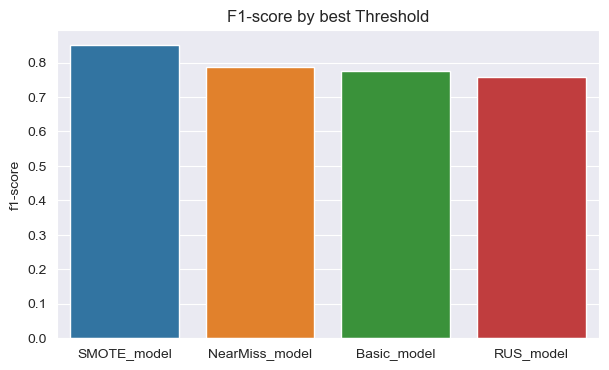

In [47]:
plt.figure(figsize=(7, 4))
plt.title('F1-score by best Threshold')
sns.barplot(x=df_thholds_f1.index, y='f1_score', data=df_thholds_f1)
plt.ylabel('f1-score')
plt.show()

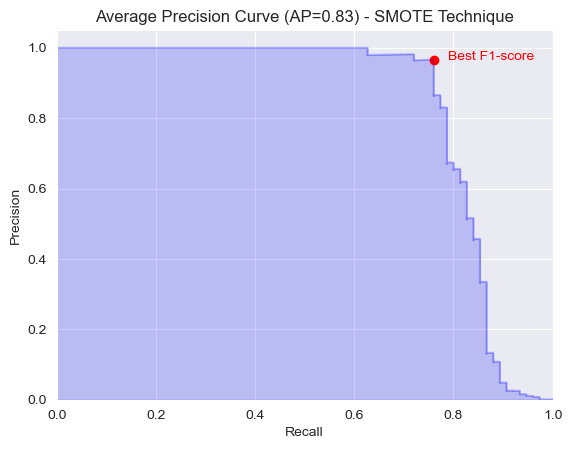

In [48]:
best_index_f1 = f1_score_index_l[-1]

plt.step(recall_l[-1], precision_l[-1], color='b', alpha=0.2, where='post')
plt.fill_between(recall_l[-1], precision_l[-1], step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.scatter(recall_l[-1][best_index_f1], precision_l[-1][best_index_f1], color='r')
plt.text(recall_l[-1][best_index_f1] + 0.03, precision_l[-1][best_index_f1], "Best F1-score", color='r')
plt.title('Average Precision Curve (AP={0:0.2f}) - SMOTE Technique'.format(df_result_rf.loc['SMOTE_model','average_precision']))
plt.show()

Regarding all models, as expected, the SMOTE technique achieved the best F1-score of 0.857 with a threshold of 0.672.

In [49]:
#y_pred_f1 = best_model_rf_smote.predict_proba(X_test)[:, 1]
#print(y_pred_f1)
#y_threshold = (y_pred_f1 >= 0.592).astype(int)
#(y_threshold ==0).sum() 
y_pred_over = best_model_rf_smote.predict(X_test)

## Feature Importance:

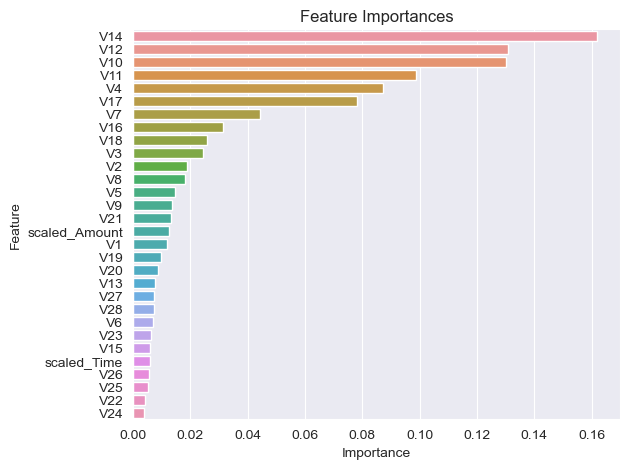

In [50]:
importances = best_model_rf_smote.feature_importances_

# Create a DataFrame with the feature names and importances
feature_importances = pd.DataFrame({'Feature': df_raw_sc.drop('Class', axis=1).columns,
                                    'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_sorted = feature_importances.sort_values('Importance', ascending=False)

# Create the bar plot using seaborn
plt.figure()#figsize=(10, 6)
sns.barplot(y=feature_importances_sorted['Feature'], x=feature_importances_sorted['Importance'], orient='h')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In descending order, the features V14, V10, V12, V11, V4... are the ones that are more relevant in predicting fraudulent transactions using the Random Forest model.

### Shapley Mean Values:

This plot presents the absolute mean of all Shap values. Therefore, the larger the value, the more relevant the feature is.

In [52]:
explainer = shap.TreeExplainer(best_model_rf_smote)
shap_values = explainer.shap_values(X_test)

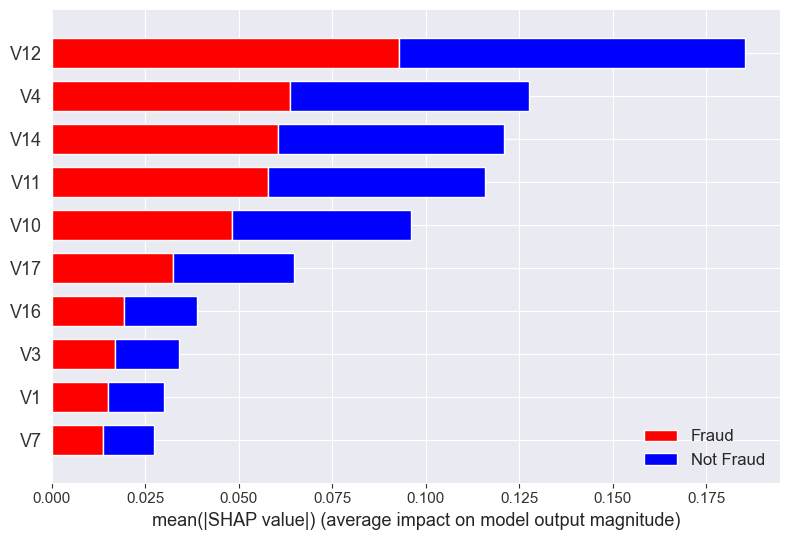

In [53]:
color_mapping = lambda i: "blue" if i == 1 else "red"
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names={0:'Not Fraud', 1:'Fraud'}, 
                  max_display=10, color=color_mapping) 

In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_over).ravel()
print(f'Real Values\n0 --> {y_test.value_counts()[0]}\n1 --> {y_test.value_counts()[1]}\n')
print(f'Predict Values\n0 --> {(y_pred_over==0).sum()}\n1 --> {(y_pred_over==1).sum()}\n')
print(f'TN: {tn} TP: {tp} FN: {fn} FP: {fp}')

#TP,TN,FP,FN indexes
index_FN = y_test[(y_test!=y_pred_over) & (y_test==1)].index.values
index_FP = y_test[(y_test!=y_pred_over) & (y_test==0)].index.values
index_TN = y_test[(y_test==y_pred_over) & (y_test==0)].index.values
index_TP = y_test[(y_test==y_pred_over) & (y_test==1)].index.values
index_FN_shapley = index_FN - y_test.index[0]
index_FP_shapley = index_FP - y_test.index[0]
index_TN_shapley = index_TN - y_test.index[0]
index_TP_shapley = index_TP - y_test.index[0]

Real Values
0 --> 56887
1 --> 75

Predict Values
0 --> 56900
1 --> 62

TN: 56882 TP: 57 FN: 18 FP: 5


### Summary Plot:

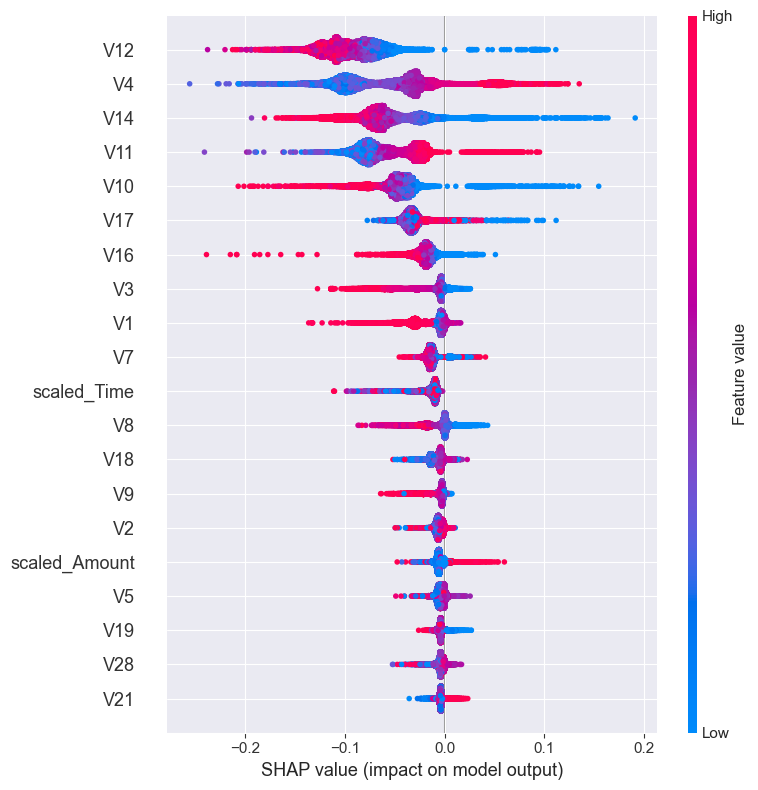

In [55]:
shap.summary_plot(shap_values[1], X_test, plot_size=(8,8))

By plotting the distribution of the SHAP values for each feature, we can observe that a majority of the values are negative, largely due to the prevalence of negative cases in the dataset. When examining the first few features, we can draw the following conclusions:

- When the feature V12 has a higher value, it decreases the probability of being a fraudulent transaction. The same effect is observed for the features V14 and V10.

- Conversely, when the features V4 and V11 have high values, there is an increase in the probability of being fraudulent.

The values presented in the plot validate the correlation matrix. V11 and V14 exhibit a positive correlation with the fraudulent class, while V10, V12, and V14 show a negative correlation with the fraudulent class.

Features like V19, V28, and V21 did not significantly contribute to the model's prediction, as indicated by their Shap values being close to zero. Therefore, these features could be either combined with others or removed in order to reduce the model's complexity.

### Force Plot:

It is important to note that the color red represents an increase in the chance of a transaction being fraudulent, meaning that the Shapley value is positive (regardless of whether the feature itself is positive or negative, and its magnitude). On the other hand, the color blue represents a decrease in the chance of a transaction being fraudulent (Shapley value < 0), indicating that the variable is pushing the value towards a non-fraudulent transaction.

### Ploting all True Positives:

In [103]:
shap.force_plot(explainer.expected_value[1], shap_values[1][index_TP_shapley], X_test.iloc[index_TP_shapley,:]) 

<img src="shap_force1.png" alt="drawing" width="950"/>

Most of the instances that were correctly predicted as positive or fraudulent were influenced by the variable V14, followed by a group of features of similar magnitude, such as V10, V12 and others. Additionally, features with negative Shapley values, which are expected to decrease the chances of fraud, had relatively smaller values.

#### Ploting all False Negatives:

In [102]:
shap.force_plot(explainer.expected_value[1], shap_values[1][index_FN_shapley], X_test.iloc[index_FN_shapley,:])

<img src="shap_force2.png" alt="drawing" width="950"/>

These values were positive but were incorrectly predicted as negative, mainly because the feature values had the opposite direction of what was expected. Similar to the true positive case mentioned earlier, features like V14, V12, and V10 had negative Shapley values instead of positive values, which contributed to the incorrect predictions. (They appear to be non-fraudulent transactions, making them difficult to predict as fraudulent)

#### Ploting all True Negatives:

In [114]:
shap.force_plot(explainer.expected_value[1], shap_values[1][index_TN_shapley[0:100]], X_test.iloc[index_TN_shapley[0:100],:])

<img src="shap_force3.png" alt="drawing" width="950"/>

The true negative (TN) values were correctly predicted due to a set of features with negative Shapley values, primarily driven by V12, V11, V4, and V14.

#### Ploting all False Positives:

In [115]:
shap.force_plot(explainer.expected_value[1], shap_values[1][index_FP_shapley], X_test.iloc[index_FP_shapley,:])

<img src="shap_force4.png" alt="drawing" width="950"/>

These values were negative but were incorrectly predicted as positive, primarily because the feature values of V10, V17 and V12 were similar in fraudulent transactions. Some instances had a predicted probability of around 0.5, indicating uncertainty in the classification. Increasing the threshold slightly could potentially correct these predictions.

#### Example of a waterfall plot for a false negative (FN) case:

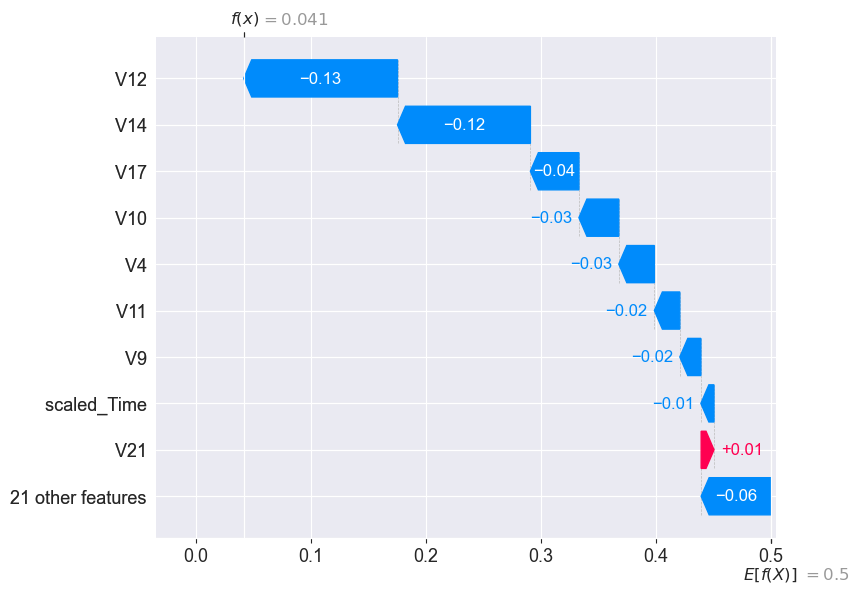

In [63]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][index_FN_shapley[7]], 
                                       features = X_test.iloc[index_FN_shapley[7],:]) #, feature_names= X_test.columns

In this particular case, it can be observed that the features V12, V14 and V17 had a greater impact on predicting the wrong result, while only V21 helped improve the probability of it being positive. What can be inferred from this? I believe this is a difficult scenario to predict as fraudulent (features had the opposite expected values) or it could be attributed to incorrect data. (probability to be fraudulent: f(x)=0.041).